In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

# Pathfinder

In this notebook we introduce the pathfinder algorithm and we show how to use it as a variational inference method or as an initialization tool for MCMC kernels.

In [2]:
import jax
import jax.numpy as jnp
import jax.random as random

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.datasets import make_biclusters

import blackjax

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (10, 6)

In [4]:
%load_ext watermark
%watermark -d -m -v -p jax,jaxlib,blackjax

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

jax     : 0.2.24
jaxlib  : 0.1.73
blackjax: 0.3.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.72-microsoft-standard-WSL2
Machine     : x86_64
Processor   : 
CPU cores   : 8
Architecture: 64bit



## The data

We create two clusters of points using [scikit-learn's `make_bicluster` function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_biclusters.html?highlight=bicluster%20data#sklearn.datasets.make_biclusters).

In [5]:
num_points = 50
X, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

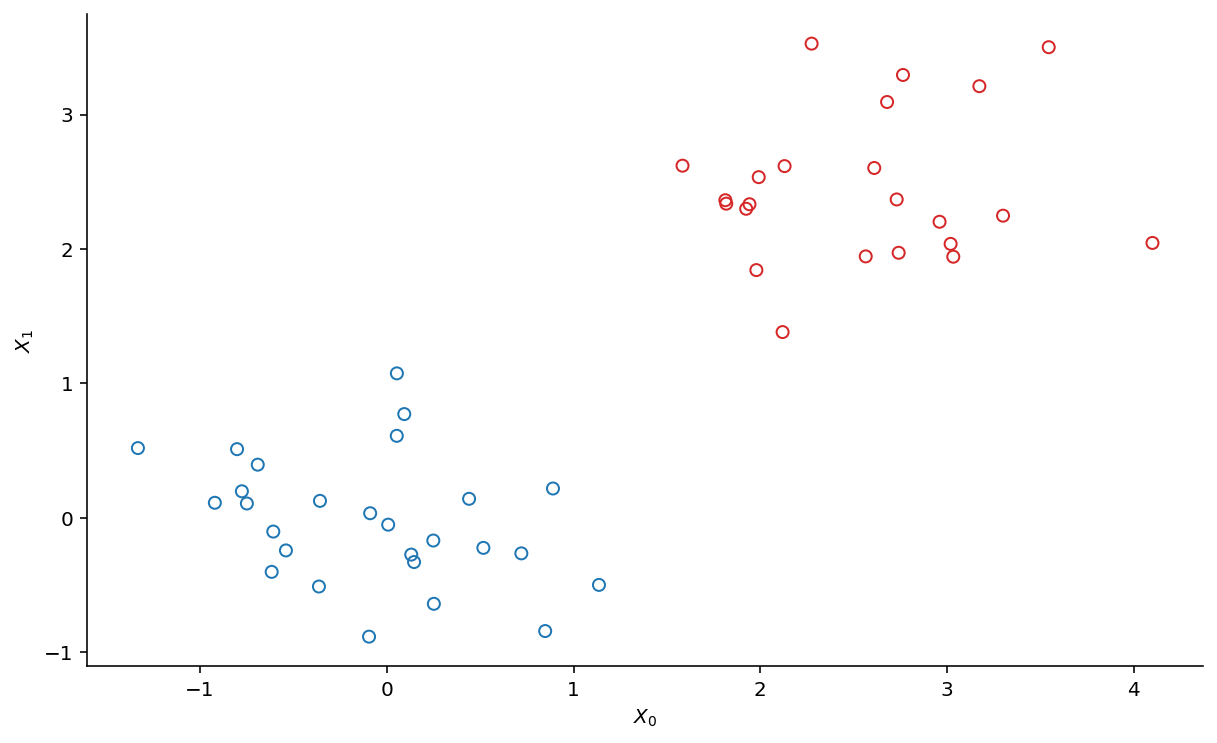

In [6]:
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$")
plt.show()

## The model

We use a simple logistic regression model to infer to which cluster each of the points belongs. We note $y$ a binary variable that indicates whether a point belongs to the first cluster :

$$
y \sim \operatorname{Bernoulli}(p)
$$

The probability $p$ to belong to the first cluster commes from a logistic regression:

$$
p = \operatorname{logistic}(\Phi\,\boldsymbol{w})
$$

where $w$ is a vector of weights whose priors are a normal prior centered on 0:

$$
\boldsymbol{w} \sim \operatorname{Normal}(0, \sigma)
$$

And $\Phi$ is the matrix that contains the data, so each row $\Phi_{i,:}$ is the vector $\left[X_0^i, X_1^i\right]$

In [7]:
Phi = X
N, M = Phi.shape


def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log(1 + jnp.exp(z))


def logprob_fn(w, alpha=1.0):
    """The log-probability density function of the posterior distribution of the model."""
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))
    prior_term = alpha * w @ w / 2

    return -prior_term + log_likelihood_term.sum()

## Pathfinder: parallel quasi-newton variational inference 

Starting from a random initialization, Pathfinder locates normal approximations to the target
density along a quasi-Newton optimization path, with local covariance estimated using the inverse Hessian
estimates produced by the optimizer. Pathfinder returns draws from the approximation with the lowest
estimated Kullback-Leibler (KL) divergence to the true posterior.
The optimizer is the limited memory BFGS algorithm.

To help understand the approximations that pathfinder evaluates during its run, here we plot for each step of the L-BFGS optimizer the approximation of the posterior distribution of the model derived by pathfinder and its ELBO:

In [8]:
rng_key = random.PRNGKey(314)
w0 = random.multivariate_normal(rng_key, 3. + jnp.zeros(M), jnp.eye(M))
path = blackjax.vi.pathfinder.init(rng_key, logprob_fn, w0, return_path=True)

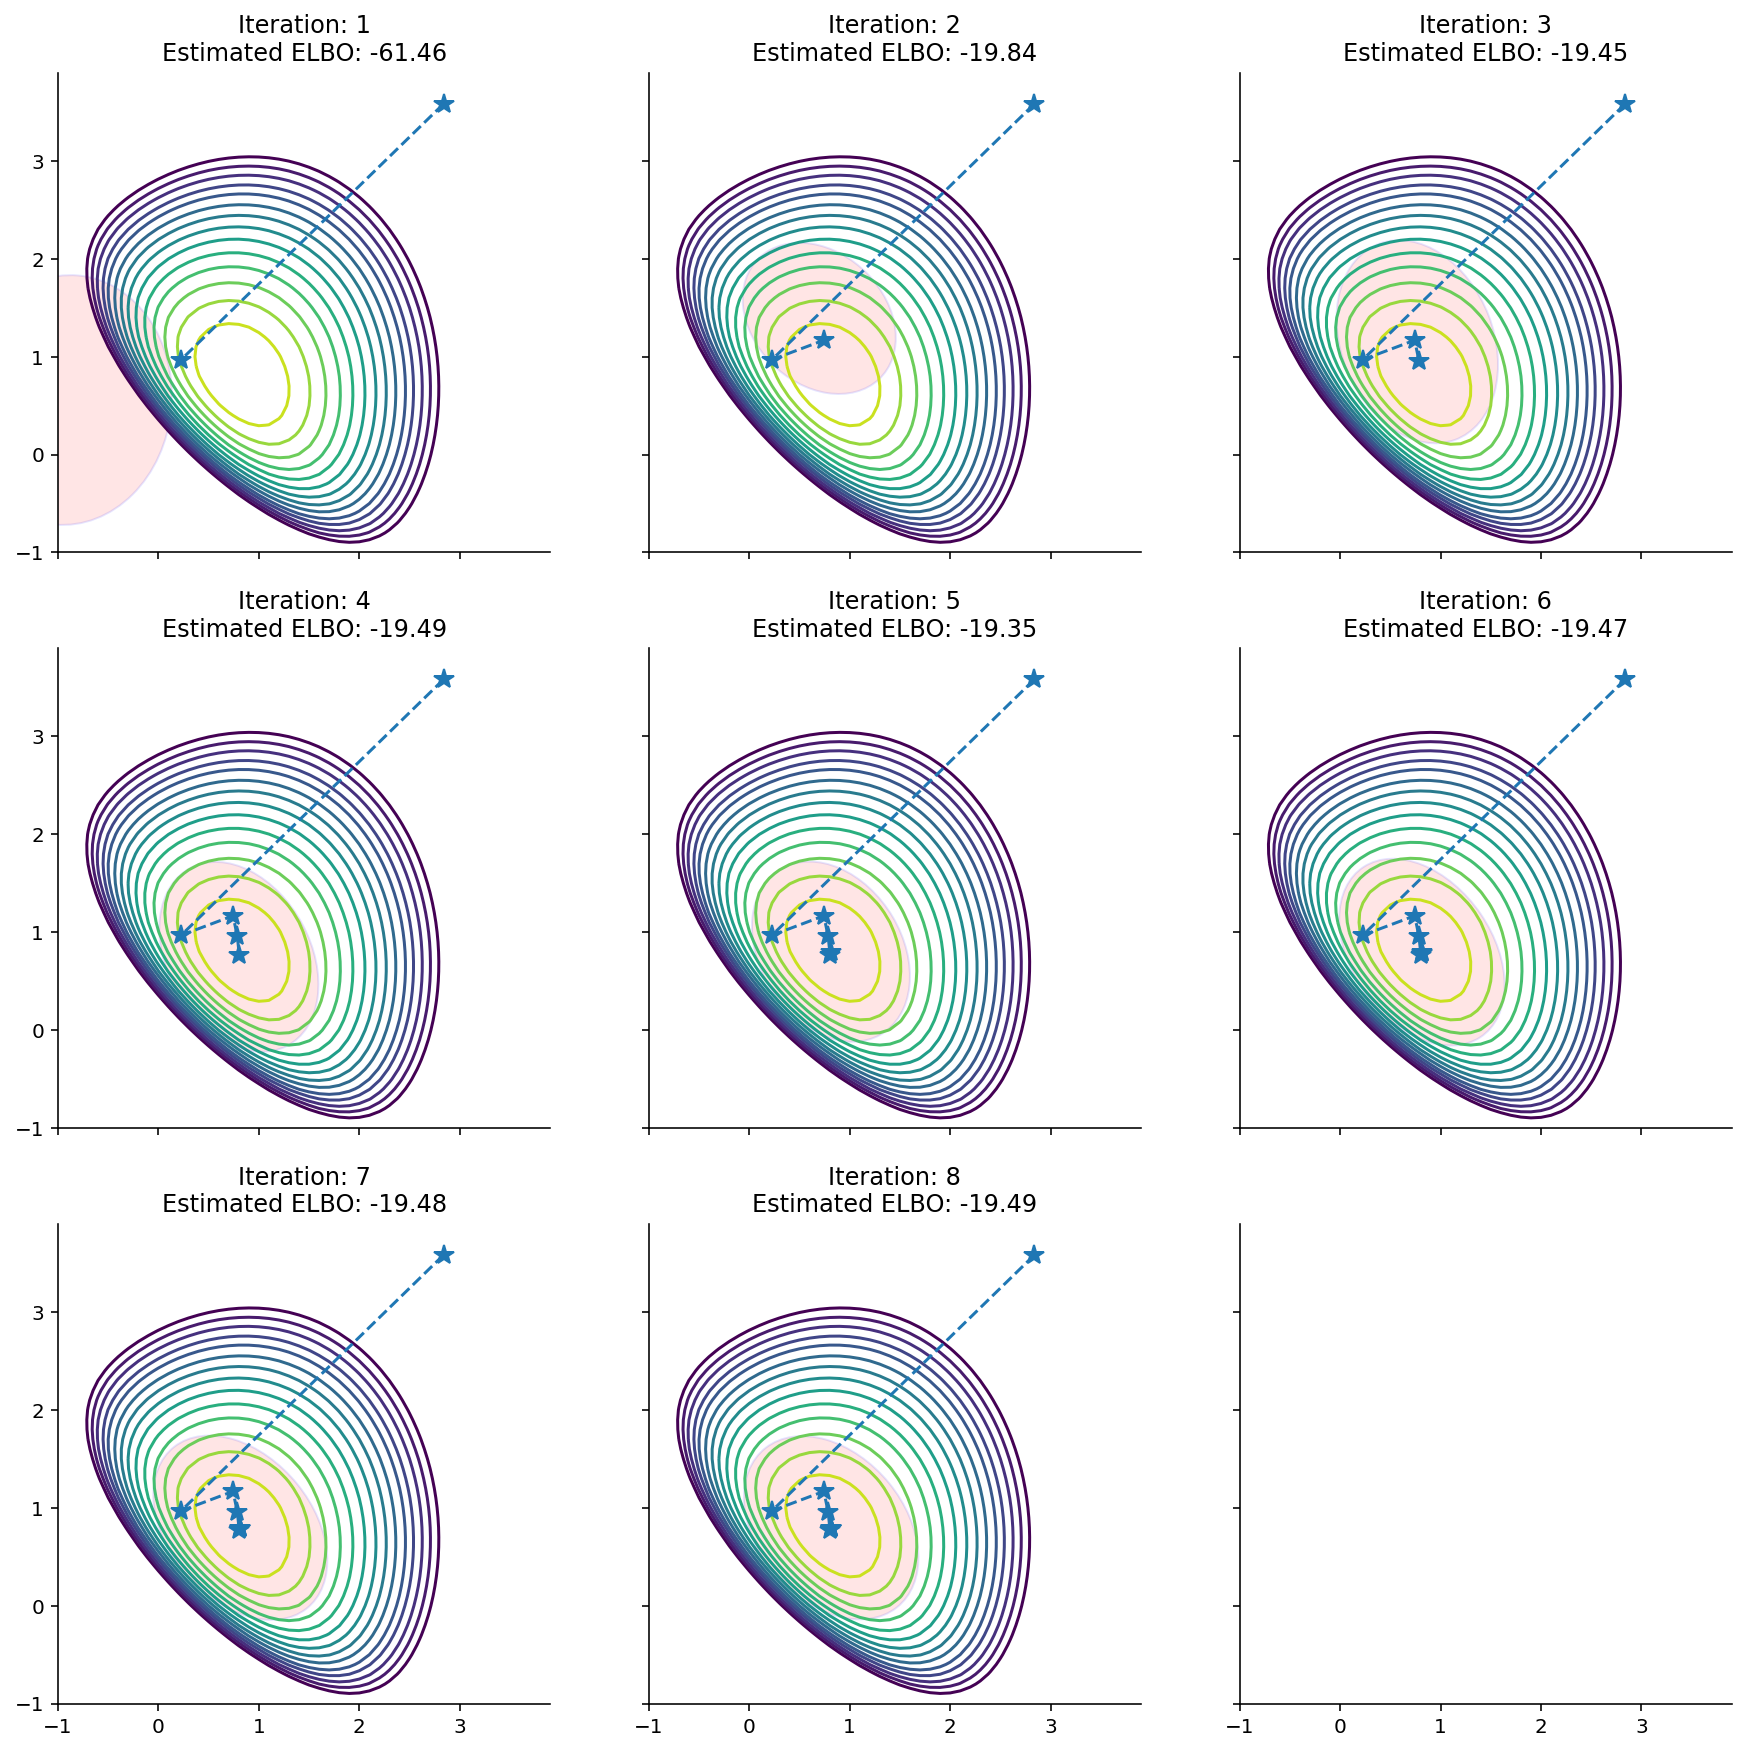

In [9]:
def ellipse_confidence(mu, cov, ax, c, n_std=2.):
    import numpy as np
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ellipse = Ellipse(xy=(*mu,),
                      width=lambda_[0]*n_std*2, height=lambda_[1]*n_std*2,
                      angle=np.degrees(np.arctan2(*v[:,0][::-1])),
                     facecolor=c,edgecolor="b", alpha=0.1)
    return ax.add_artist(ellipse)

step = 0.1
x_, y_ = jnp.mgrid[-1:4:step, -1:4:step]
pos_ = jnp.dstack((x_, y_))
logp_ = jax.vmap(logprob_fn)(pos_.reshape(-1,M)).reshape(pos_.shape[0], pos_.shape[1])
levels_ = jnp.percentile(logp_.flatten(),jnp.linspace(60,100,15))


steps = (path.i>0).sum()
rows = int(jnp.ceil(steps / 3))
fig,axs = plt.subplots(rows, 3, figsize=(15, 5*rows), sharex=True, sharey=True)
offset = jnp.where(path.i==0)[0][0]

for i,ax in zip(range(1,steps+1), axs.flatten()):
    
    ax.contour(x_,y_,logp_, levels=levels_)
    state = jax.tree_map(lambda x: x[offset+i], path)
    sample_state = blackjax.vi.pathfinder.sample_from_state(rng_key, state, 10_000)
    x_path = path.x[offset:offset+i+1] 
    ax.plot(x_path[:,0], x_path[:,1], marker="*", linestyle="--",markersize=10)
    mu_i, cov_i = sample_state.mean(0), jnp.cov(sample_state,rowvar=False)
    ellipse_confidence(mu_i,cov_i, ax, "r")
    ax.set_title(f"Iteration: {i}\nEstimated ELBO: {state.elbo:.2f}")
fig.show()

## Pathfinder as a variational inference method

Pathfinder can be used as a variational inference method, using its kernel API:

In [10]:
pathfinder = blackjax.kernels.pathfinder(rng_key, logprob_fn)
state = pathfinder.init(w0)

Since `blackjax` does not provide an inference loop we need to implement one ourselves:

In [11]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    return jax.lax.scan(one_step, initial_state, keys)

We can now run the inference:

In [12]:
_, rng_key = random.split(rng_key)
_, (_, samples) = inference_loop(rng_key, pathfinder.step, state, 5_000)

And display the trace:

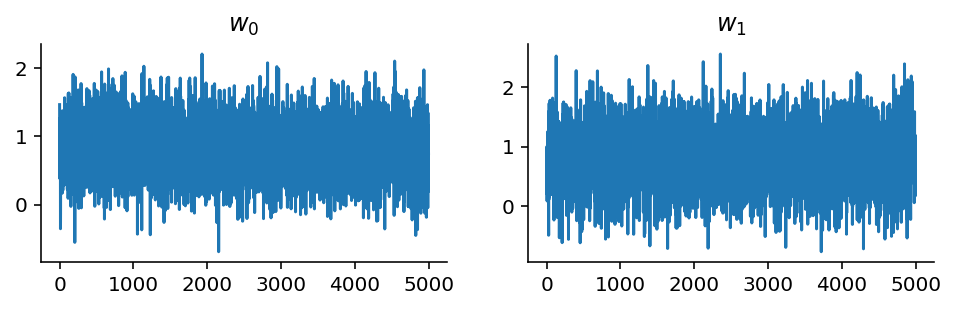

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
for i, axi in enumerate(ax):
    axi.plot(samples[:, i])
    axi.set_title(f"$w_{i}$")
plt.show()

Please note that pathfinder is implemented as follows:
* it runs L-BFGS optimization and finds the best approximation in the `init` phase
* `step` phase it's just sampling from a multinormal distribution, whose parameters have been already estimated


hence it makes sense to `jit` the `init` function and then use the `blackjax.vi.pathfinder.sample_from_state` helper function instead of implementing the inference loop:

In [14]:
state = jax.jit(pathfinder.init)(w0)
samples = blackjax.vi.pathfinder.sample_from_state(rng_key, state, 5_000)

Quick comparison against `rmh` kernel:

In [15]:
rmh = blackjax.kernels.rmh(logprob_fn, sigma=jnp.ones(M) * 0.7)
state_rmh = rmh.init(w0)
_, (samples_rmh, _) = inference_loop(rng_key, rmh.step, state_rmh, 5_000)

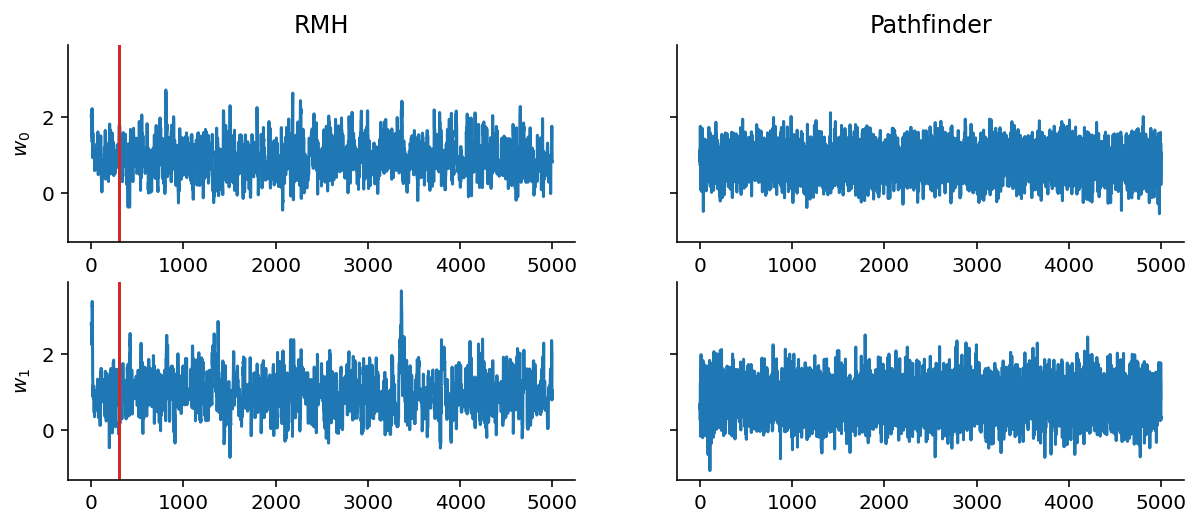

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharey=True)
for i in range(2):
    ax[i,0].plot(samples_rmh.position[:, i])
    ax[i,0].axvline(x=300, c="tab:red")
    ax[i,0].set_ylabel(f"$w_{i}$")
    ax[i,1].plot(samples[:, i])

ax[0,0].set_title("RMH")
ax[0,1].set_title("Pathfinder")
fig.show()

### Pathfinder as an initialization tool for MCMC kernels

Pathfinder uses internally the inverse hessian estimation of the L-BFGS optimizer to evaluate the approximations to the target distribution along the quasi-Newton optimization path.

We can calculate explicitly this inverse hessian matrix for a step of the optimization path using the `blackjax.vi.pathfinder.lbfgs_inverse_hessian_formula_1` function:

In [17]:
from blackjax.vi.pathfinder import lbfgs_inverse_hessian_formula_1

inverse_mass_matrix = lbfgs_inverse_hessian_formula_1(state.alpha, state.beta, state.gamma)
inverse_mass_matrix

DeviceArray([[ 0.15398185, -0.05144304],
             [-0.05144304,  0.21578048]], dtype=float64)

This estimation of the inverse mass matrix, coupled with Nesterov's dual averaging adaptation for estimating the step size, yields an alternative adaptation scheme for initializing MCMC kernels.

This scheme is implemented in `blackjax.kernel.pathfinder_adaptation` function:

In [18]:
adapt = blackjax.kernels.pathfinder_adaptation(blackjax.nuts, logprob_fn)
state, kernel, info = adapt.run(rng_key, w0)

## Some caveats

* L-BFGS algorithm struggles with float32s and log-likelihood functions; it's suggested to use double precision numbers. In order to do that in `jax` a configuration variable needs to be set up at initialization time (see [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision)). That's what we did in the first cell.


* It may make sense to start pathfinder with a "bad" initialization point, in order to make the L-BFGS algorithm run longer and have more datapoints to estimate the inverse hessian matrix.